In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/My Drive/ECE1512')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2


In [4]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [5]:
from mnist1d_utils import *

# Dataset

In [6]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

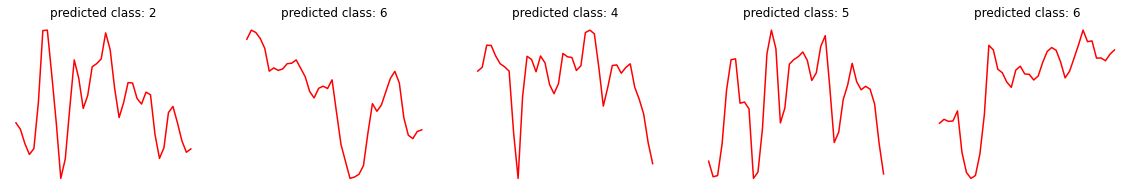

In [7]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

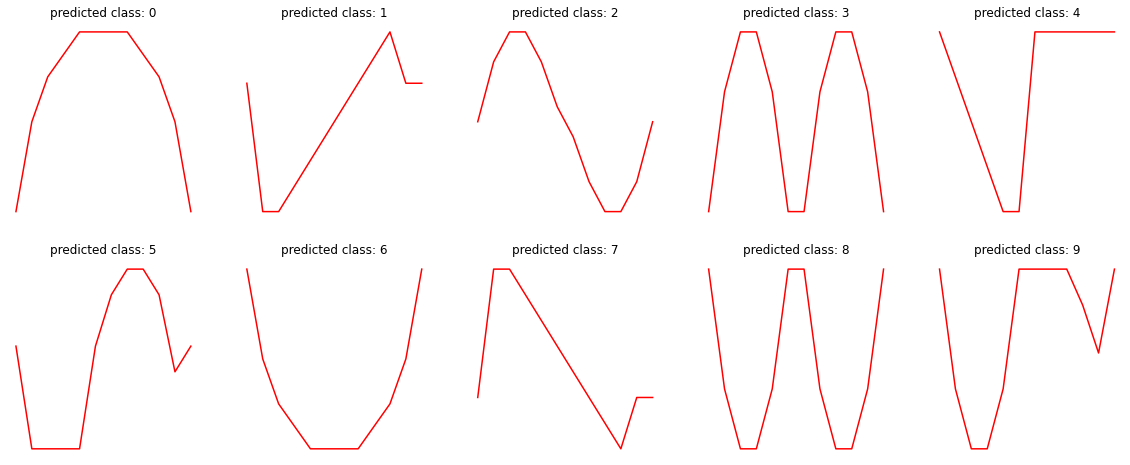

In [8]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [9]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

#Task1: 1-Dimensional digit *classification*

* Task1 - Q1

In [10]:
##Task1-Question1
weight_decay = 5e-4
model = Sequential()
#Your code starts from here 
model.add(Conv1D(25, 5, padding='same', activation='relu', input_shape=(40,1)))
model.add(Conv1D(25, 3, padding='same', activation='relu'))
model.add(Conv1D(25, 3, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(10, activation='softmax', ))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

* Task1 - Q2

*Code refer to Reference[1]*

In [11]:
model.compile(optimizer='sgd',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
history = model.fit(x=np.expand_dims(dataset['x'], axis= -1), y= dataset['y'], epochs=200, validation_split=0.1 
                   )

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


113/113 [==============================] - 2s 8ms/step - loss: 2.2747 - accuracy: 0.1267 - val_loss: 2.2389 - val_accuracy: 0.1425
Epoch 2/200
113/113 [==============================] - 1s 7ms/step - loss: 2.1442 - accuracy: 0.2044 - val_loss: 2.0667 - val_accuracy: 0.1950
Epoch 3/200
113/113 [==============================] - 1s 7ms/step - loss: 1.9163 - accuracy: 0.2483 - val_loss: 1.8576 - val_accuracy: 0.2425
Epoch 4/200
113/113 [==============================] - 1s 8ms/step - loss: 1.7772 - accuracy: 0.2931 - val_loss: 1.7701 - val_accuracy: 0.2575
Epoch 5/200
113/113 [==============================] - 1s 7ms/step - loss: 1.7096 - accuracy: 0.3086 - val_loss: 1.7132 - val_accuracy: 0.3025
Epoch 6/200
113/113 [==============================] - 1s 7ms/step - loss: 1.6575 - accuracy: 0.3333 - val_loss: 1.6574 - val_accuracy: 0.3225
Epoch 7/200
113/113 [==============================] - 1s 6ms/step - loss: 1.6025 - accuracy: 0.3603 - val_loss: 1.6349 - val_accuracy: 0.3400
Epoch 8/200

# Plotting the training progress

* Task1-Question3

  a. Plot for loss curve and for accuracy curve. [0.5 Marks]

  b. Overall classification accuracy on the test set. [0.25 Marks]

  c. Class-wise classification accuracy for all classes. [0.25 Marks]

  d. Plot the classification ROC and AUC curves for each class. [0.5 Marks]

  e. Plot the normalized confusion matrix. [0.25 Marks]

  f. Precision, Recall, and F-1 score on the test set. [0.5 Marks]

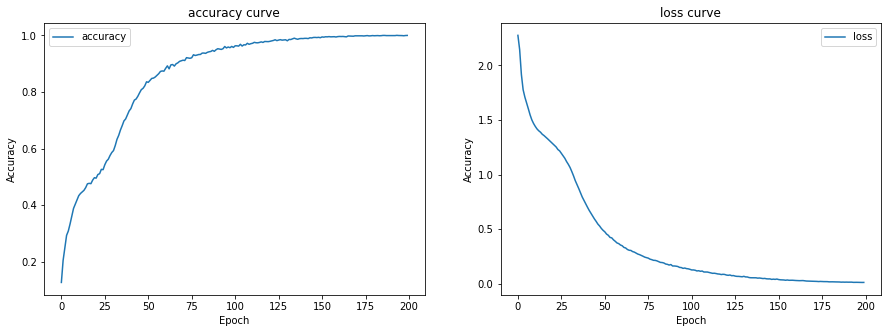

In [13]:
##Task1-Question3.a Plot for loss curve and for accuracy curve.
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('accuracy curve')
plt.legend()


plt.subplot(122)
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('loss curve')
plt.legend()

In [14]:
##b. Overall classification accuracy on the test set. [0.25 Marks]
print("overall accuracy:")
results = model.evaluate(dataset['x_test'], dataset['y_test'],verbose=2)

overall accuracy:


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


32/32 - 0s - loss: 0.4518 - accuracy: 0.8870 - 302ms/epoch - 9ms/step


In [15]:
## c. Class-wise classification accuracy for all classes. [0.25 Marks]
from sklearn.metrics import classification_report
import numpy as np

y_pred = np.argmax(model(dataset['x_test']),axis=1)
# y_test = np.argmax(dataset['y_test'])
print('Class-wise classification accuracy is:')
print(classification_report(dataset['y_test'], y_pred))

Class-wise classification accuracy is:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.91      0.92      0.91       104
           2       0.78      0.88      0.83        89
           3       0.97      0.96      0.97       106
           4       0.85      0.85      0.85       106
           5       0.81      0.87      0.84        98
           6       0.99      0.92      0.95        99
           7       0.87      0.82      0.84        96
           8       0.96      0.89      0.92        98
           9       0.77      0.77      0.77       102

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



*ROC,AUC Code refer to Reference[2]*

*OneHotEncoder Code refer to Reference[3]*

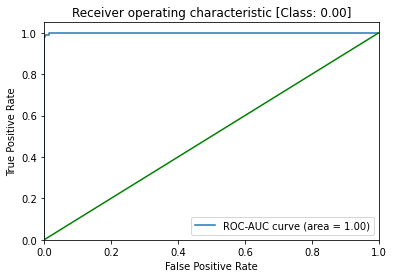

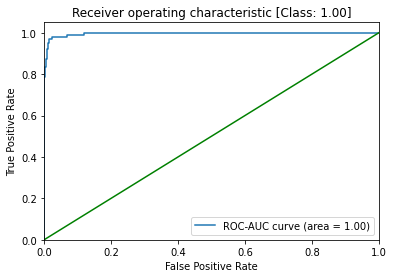

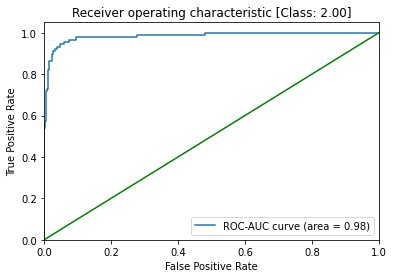

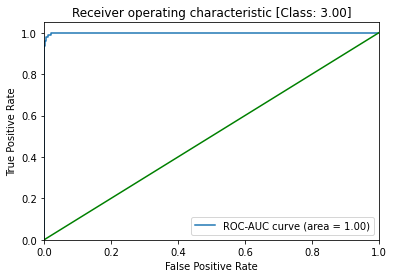

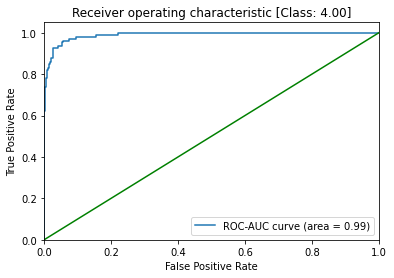

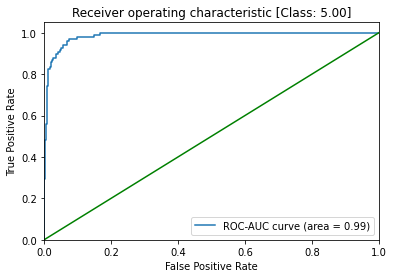

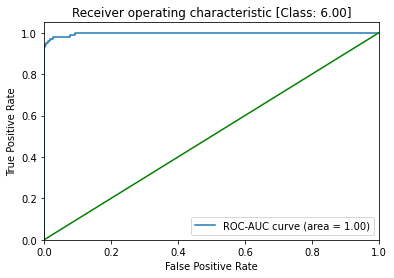

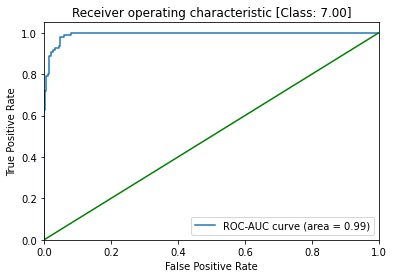

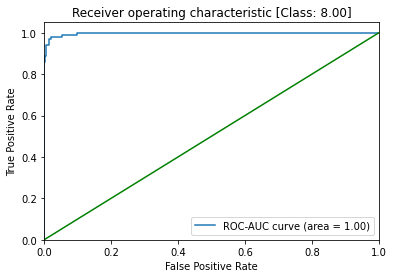

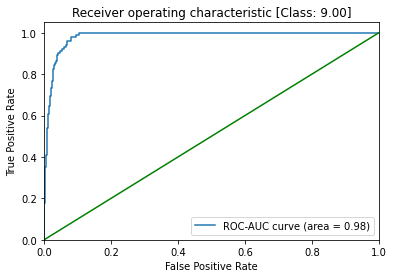

In [16]:
#d. Plot the classification ROC and AUC curves for each class.
plt.figure()
from sklearn.preprocessing import OneHotEncoder

prob = model(dataset['x_test'])
enc = OneHotEncoder(handle_unknown='ignore')

y_reshape= dataset['y_test'].reshape(-1, 1)
enc.fit(y_reshape)
enc.categories
y_re= enc.transform(y_reshape).toarray()

y_sfit = model(dataset['x_test'])
predict = np.argmax(prob, axis=1)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_re[:, i], y_sfit[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    plt.plot(fpr[i], tpr[i], label="ROC-AUC curve (area = {1:0.2f})".format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color="green")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic [Class: %0.2f]" % i)
    plt.legend()
    plt.show()

*Confusion matrix Code refer to Reference[4]*

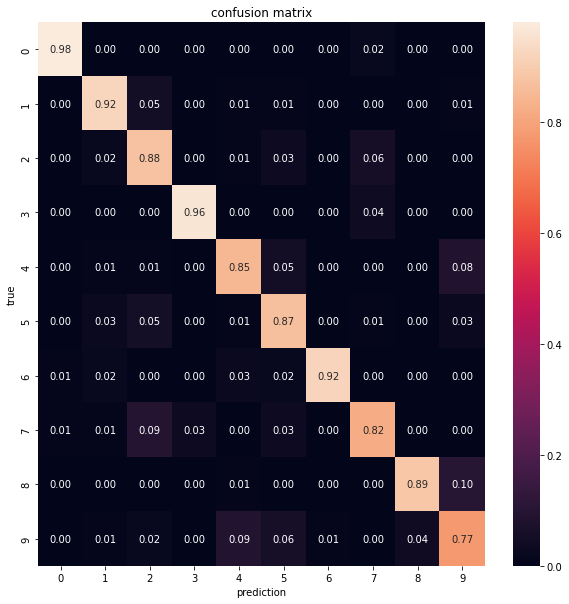

In [17]:
# e. Plot the normalized confusion matrix. [0.25 Marks]

from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = metrics.confusion_matrix(dataset['y_test'], predict, normalize='true')

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=['0','1','2','3','4','5','6','7','8','9'], yticklabels=['0','1','2','3','4','5','6','7','8','9'])
plt.ylabel('true')
plt.xlabel('prediction')
plt.title('confusion matrix')
plt.show(block=False)

In [18]:
# f. Precision, Recall, and F-1 score on the test set. [0.5 Marks]
from sklearn.metrics import precision_score, recall_score,f1_score
print("precision score is:", precision_score(dataset['y_test'], predict,average='micro'))
print("recall is:",recall_score(dataset['y_test'], predict,average='micro'))
print("f1_scrore is:", f1_score(dataset['y_test'], predict,average='micro'))


precision score is: 0.887
recall is: 0.887
f1_scrore is: 0.887


* Task1 - Question4

Successful case:

This is a Successful example of the model because it has a very high confidence score and provides a correct prediction of the class.

In [19]:
 #task1  question 4
#Show some examples of the success/failure cases of the model. 
#Among which two classes misclassification happens the most? Provide your insights and support your answers with analytic reasons. [1.25 Marks] 
input = np.expand_dims(np.expand_dims(dataset['x_test'][8], axis=0), axis=-1)
label = dataset['y_test'][8]
print('Correct : '+str(label))
print('Predicted : '+str(np.argmax(model(np.expand_dims(np.expand_dims(dataset['x_test'][8], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(dataset['x_test'][8], axis=0), axis=-1)).numpy()[0,label]))


Correct : 5
Predicted : 5
Confidence score for the correct label: 0.9999974


In [20]:
for i in range(dataset['x_test'].shape[0]):
  input = np.expand_dims(np.expand_dims(dataset['x_test'][i], axis=0), axis=-1)
  label = dataset['y_test'][i]
  if (model(np.expand_dims(np.expand_dims(dataset['x_test'][i], axis=0), axis=-1)).numpy()[0,label]) <0.5:
    print(i)
    print('Correct : '+str(label))
    print('Predicted : '+str(np.argmax(model(np.expand_dims(np.expand_dims(dataset['x_test'][i], axis=0), axis=-1)).numpy())))
    print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(dataset['x_test'][i], axis=0), axis=-1)).numpy()[0,label]))


3
Correct : 9
Predicted : 2
Confidence score for the correct label: 0.06873039
4
Correct : 4
Predicted : 1
Confidence score for the correct label: 0.25788444
16
Correct : 1
Predicted : 2
Confidence score for the correct label: 0.0001759136
17
Correct : 4
Predicted : 9
Confidence score for the correct label: 0.14238326
19
Correct : 9
Predicted : 5
Confidence score for the correct label: 0.042470418
22
Correct : 5
Predicted : 7
Confidence score for the correct label: 0.014055775
25
Correct : 1
Predicted : 2
Confidence score for the correct label: 0.002313798
29
Correct : 7
Predicted : 1
Confidence score for the correct label: 0.0017178869
30
Correct : 8
Predicted : 9
Confidence score for the correct label: 0.017427227
33
Correct : 3
Predicted : 7
Confidence score for the correct label: 0.00029560886
55
Correct : 8
Predicted : 9
Confidence score for the correct label: 0.019945957
58
Correct : 5
Predicted : 9
Confidence score for the correct label: 0.15037453
87
Correct : 9
Predicted : 5
C

Failure case: 

This is a failure example of the model because it has a very low confidence score and provides an incorrect prediction of the class.

In [21]:
input = np.expand_dims(np.expand_dims(dataset['x_test'][16], axis=0), axis=-1)
label = dataset['y_test'][16]
print('Correct : '+str(label))
print('Predicted : '+str(np.argmax(model(np.expand_dims(np.expand_dims(dataset['x_test'][16], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(dataset['x_test'][16], axis=0), axis=-1)).numpy()[0,label]))


Correct : 1
Predicted : 2
Confidence score for the correct label: 0.0001759136


Two classes misclassification happen the most:

In [22]:
cm2=cm
mask = np.ones(cm2.shape, dtype=bool)
np.fill_diagonal(mask, 0)
mr = cm2[mask].max()
print(np.where(cm2 == mr))
print('Based on the confusion matrix with max number masked, we can see the two classes misclassification happen the most is Gourp 4 and Group 9')
print('The misclassification rate is :', mr )


(array([8]), array([9]))
Based on the confusion matrix with max number masked, we can see the two classes misclassification happen the most is Gourp 4 and Group 9
The misclassification rate is : 0.10204081632653061


# Explanation

In [23]:
from xai_utils import *

Take a test sample

In [24]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [25]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 0.99999905


## SISE (Semantic Input Sampling for Explanation)

In [34]:
explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)

Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

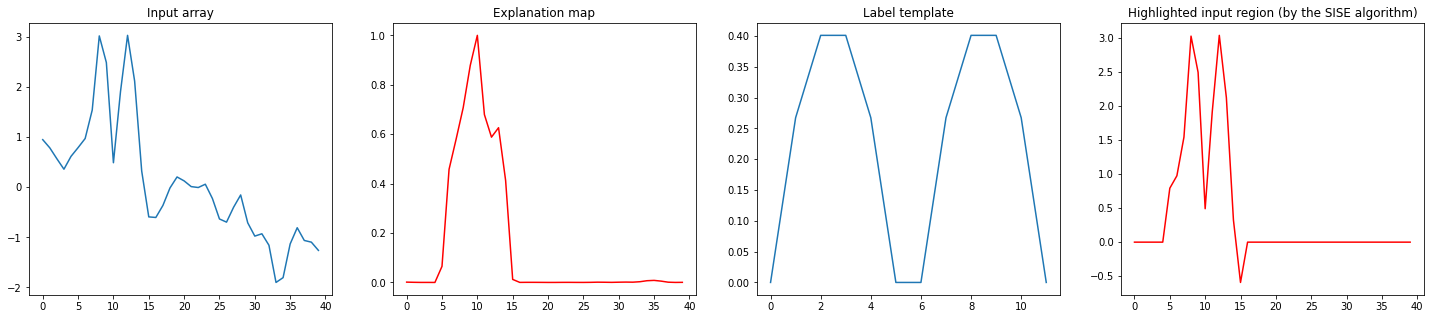

In [35]:
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')

## Grad-CAM

In [36]:
explanation = grad_cam(model, input, 'conv1d_2')

Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

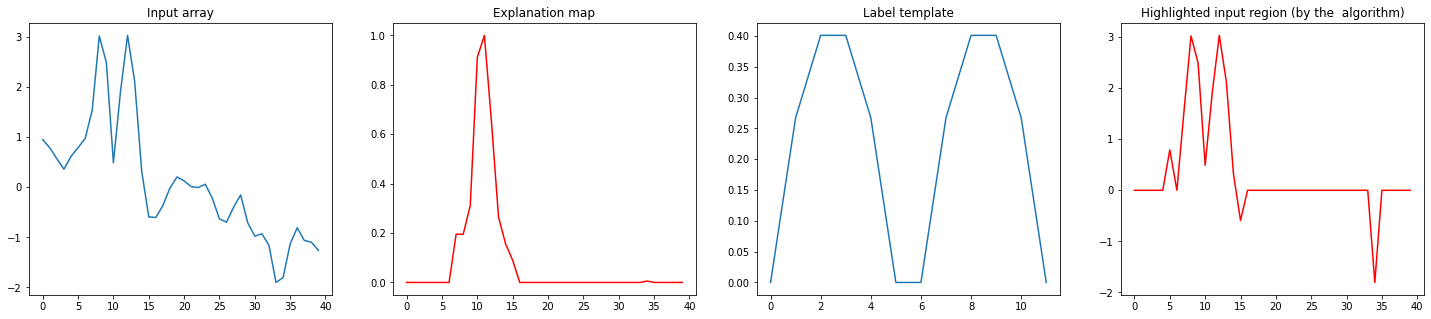

In [37]:
threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

#Task 2: CNN interpretation
#Model 1 - SmoothGrad 
using support .py files

*Code refer to Reference[5]*

In [31]:
from call_smoothgrad44 import SmoothGradCallback

sgmodel = model
callbacks = [
    SmoothGradCallback(
        validation_data=(dataset['x_test'], dataset['y_test']),
        class_index=1,
        num_samples=10,
        noise=0.5,
        output_dir=('./logs8/smoothgrad'),
    )
]

sg= sgmodel.fit(dataset['x'], dataset['y'], batch_size=1, epochs=3, callbacks=callbacks)


Epoch 1/3
4000/4000 [==============================] - 14s 4ms/step - loss: 0.2529 - accuracy: 0.9172
Epoch 2/3
4000/4000 [==============================] - 31s 8ms/step - loss: 0.1908 - accuracy: 0.9392
Epoch 3/3
4000/4000 [==============================] - 30s 8ms/step - loss: 0.1434 - accuracy: 0.9553


In [43]:
from core_smoothgrad44 import SmoothGrad

explanation = SmoothGrad()
validation_data=dataset['x_test'], dataset['y_test']

gridSmoothGrad = explanation.explain(validation_data, sgmodel, class_index=1, num_samples=10, noise=0.5)


In [44]:
gridSmoothGrad

array([[3.1728955e-04, 1.0148788e-01, 1.6640262e-01, ..., 9.4322562e-02,
        2.8189968e-02, 7.9576537e-02],
       [4.4325837e-03, 1.4513557e-01, 1.9379973e-01, ..., 4.5249924e-02,
        5.1847544e-02, 5.4857619e-03],
       [1.9599651e-01, 2.3859981e-01, 5.2979439e-01, ..., 1.7777237e-01,
        1.0310279e-01, 1.8670437e-01],
       ...,
       [7.2190419e-02, 2.4188825e-01, 5.6956250e-02, ..., 5.1158857e-02,
        6.1287232e-02, 3.7998807e-02],
       [1.6014690e-02, 1.4654376e-01, 1.1837054e-01, ..., 8.5501933e-01,
        4.7411734e-01, 3.3244696e-01],
       [2.0856524e-02, 5.6966746e-01, 1.0534861e+00, ..., 5.8752350e-03,
        5.2567847e-02, 3.2333679e-02]], dtype=float32)

Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

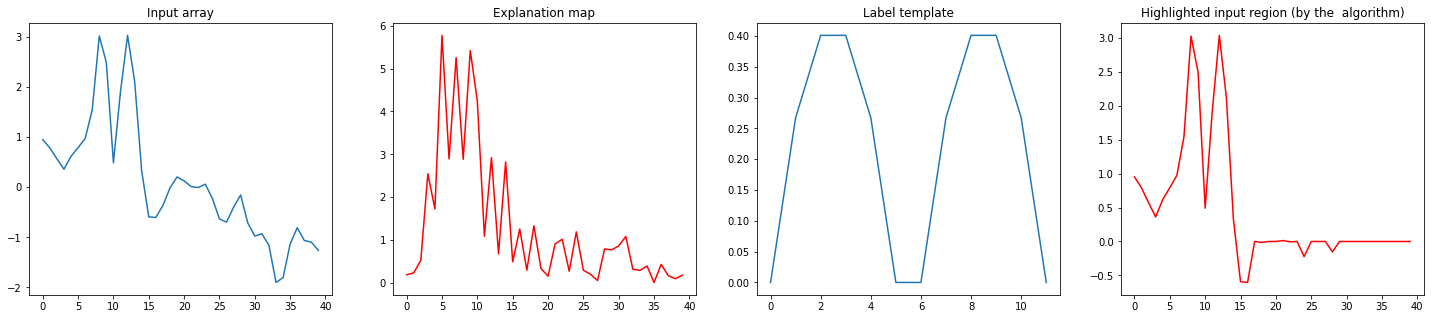

In [62]:
threshold = np.sort(gridSmoothGrad)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(gridSmoothGrad[2], 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(gridSmoothGrad>threshold)[2]), 'r')
plt.title('Highlighted input region (by the  algorithm)')

# Model 2 - IntegratedGrad
using support .py files

*Code refer to Reference[6]*

In [51]:
from integrated_gradients import *

# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method)

# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_sample = x_test[:nb_samples]
predictions = model(X_test_sample).numpy().argmax(axis=1)
explanation = ig.explain(X_test_sample, 
                         baselines=None, 
                         target=predictions)
# Metadata from the explanation object
explanation.meta

{'explanations': ['local'],
 'name': 'IntegratedGradients',
 'params': {'internal_batch_size': 100,
  'layer': 0,
  'method': 'gausslegendre',
  'n_steps': 50,
  'target_fn': None},
 'type': ['whitebox'],
 'version': '0.6.5dev'}

In [47]:
explanation

Explanation(meta={
  'name': 'IntegratedGradients',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'target_fn': None,
              'method': 'gausslegendre',
              'n_steps': 10,
              'internal_batch_size': 100,
              'layer': 0}
            ,
  'version': '0.6.5dev'}
, data={
  'attributions': [array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.67028646e-05,
         3.32243539e-04,  2.90256027e-03, -6.99290481e-04,
         8.76866502e-03, -1.73546897e-03, -4.57325562e-04,
        -3.99478024e-03,  3.57563117e-04, -6.26600394e-05,
        -1.63671591e-04,  5.96611910e-05,  2.57684856e-03,
         4.44987457e-04,  1.12471174e-03,  9.11975644e-04,
        -3.38910861e-04,  9.97461191e-05,  1.15204791e-06,
         5.07180538e-03, -1.20483719e-02,  2.11279856e-01,
         1.15431620e-01, -1.11377752e-02,  2.75709606e-02,
         7.88813438e-02,  3.76017394e-02, -6.18993410

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The Explanation object is not a dictionary anymore and accessing elements should be done via attribute access. Accessing via item will stop working in a future version.


Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

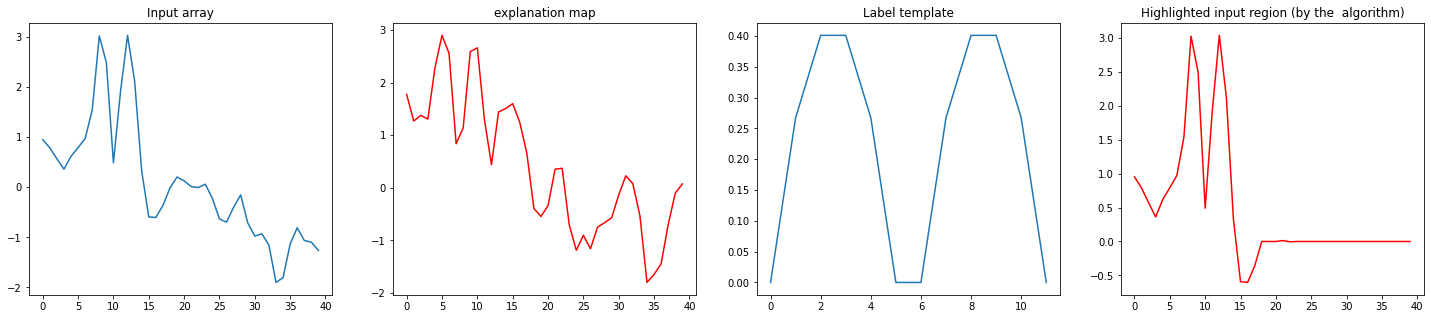

In [56]:
threshold = np.sort(explanation['X'])[-10]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation['X'][2], 'r')
plt.title('explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation['X']>threshold)[2]), 'r')
plt.title('Highlighted input region (by the  algorithm)')

# Task4: Quantitative evaluation of the attribution methods

## Quantitative evaluation

In [51]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

SISE Drop rate:

In [53]:
drop_rate = 0.
inc_rate = 0.

for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
    drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[0]
    inc_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[1]

drop_rate /= 1000
inc_rate /= 1000

In [54]:
print('drop rate is:', drop_rate)
print('increase rate is:', inc_rate)

drop rate is: 0.24232203551524775
increase rate is: 0.371


SmoothGrad Drop rate:

In [68]:
drop_rate = 0.
inc_rate = 0.

for index in range(10):
    explanation = SmoothGrad()
    validation_data=dataset['x_test'][index], dataset['y_test'][index]
    explanation_map = explanation.explain(validation_data, sgmodel, class_index=0, num_samples=20, noise=1)
    
    # prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    # explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)

    drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[0]
    inc_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)[1]

drop_rate /= 10
inc_rate /= 10

In [81]:
print('drop rate is:', drop_rate)
print('increase rate is:', inc_rate)

drop rate is: 0.4626306193871237
increase rate is: 0.583747989755455


IntegratedGrad Drop rate:

In [77]:
drop_rate = 0.
inc_rate = 0.

for index in range(10):
    # explanation = SmoothGrad()
    # validation_data=dataset['x_test'][index], dataset['y_test'][index]
    # explanation_map = explanation.explain(validation_data, sgmodel, class_index=0, num_samples=20, noise=1)
    
    # prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    # explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)

    X_test_sample = x_test[:nb_samples]
    predictions = model(X_test_sample).numpy().argmax(axis=1)
    explanation = ig.explain(X_test_sample,baselines=None,target=predictions)
    explanation_map = explanation['X']

    drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation['X'][0], class_index=np.argmax(prediction[0]), frac=0.3)[0]
    inc_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation['X'][0], class_index=np.argmax(prediction[0]), frac=0.3)[1]

drop_rate /= 10
inc_rate /= 10

In [83]:
print('drop rate is:', drop_rate)
print('increase rate is:', inc_rate)

drop rate is: 0.7832345
increase rate is: 0.8937872881111


# Reference

[1] Task 1-Question 2, model fit:
https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

[2] Task 1-Question 3.d, rocauc:
https://stackoverflow.com/questions/33547965/computing-auc-and-roc-curve-from-multi-class-data-in-scikit-learn-sklearn

[3] Task 1-Question 3.d, onehotencoder:
https://docs.w3cub.com/scikit_learn/modules/generated/sklearn.preprocessing.onehotencoder

[4] Task 1-Question 3.e, confusion matrix:
https://stackoverflow.com/questions/20927368/how-to-normalize-a-confusion-matrix

[5] Task 2-Model 1, smoothgrad: 
https://docs.seldon.io/projects/alibi/en/latest/examples/integrated_gradients_mnist.html

[6] Task 2-Model 2, IntegratedGrad: 
https://github.com/sicara/tf-explain

